## Pipeline

In [1]:
import pandas as pd

df = pd.read_csv('../../../python-machine-learning-book-3rd-edition-master/ch06/wdbc.data', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [2]:
df.shape

(569, 32)

In [3]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values

le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [4]:
le.transform(le.classes_)

array([0, 1])

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)
X_train.shape

(455, 30)

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(
    StandardScaler(),
    PCA(n_components=2),
    LogisticRegression(random_state=1, solver='lbfgs')
)
pipe_lr.fit(X_train, y_train)

y_pred = pipe_lr.predict(X_test)
print(f'Test Accuracy: {pipe_lr.score(X_test, y_test):.3f}')

Test Accuracy: 0.956


## k-fold Cross Validation

In [7]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print(f'Fold: {k + 1:2d}, Class dist.: {np.bincount(y_train[train])}, Acc: {score:.3f}')
    
print(f'CV accuracy: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')

Fold:  1, Class dist.: [256 153], Acc: 0.935
Fold:  2, Class dist.: [256 153], Acc: 0.935
Fold:  3, Class dist.: [256 153], Acc: 0.957
Fold:  4, Class dist.: [256 153], Acc: 0.957
Fold:  5, Class dist.: [256 153], Acc: 0.935
Fold:  6, Class dist.: [257 153], Acc: 0.956
Fold:  7, Class dist.: [257 153], Acc: 0.978
Fold:  8, Class dist.: [257 153], Acc: 0.933
Fold:  9, Class dist.: [257 153], Acc: 0.956
Fold: 10, Class dist.: [257 153], Acc: 0.956
CV accuracy: 0.950 +/- 0.014


In [8]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    estimator=pipe_lr,
    X=X_train,
    y=y_train,
    cv=10,
    n_jobs=1
)
print(f'CV accuracy scores: {scores}')
print(f'CS accuracy: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')

CV accuracy scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CS accuracy: 0.950 +/- 0.014


## Grid Search

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))
param_range = [0.0001, 0.001, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [
    {
        'svc__C': param_range,
        'svc__kernel': ['linear'],
    }, {
        'svc__C': param_range,
        'svc__gamma': param_range,
        'svc__kernel': ['rbf'],
    }
]

gs = GridSearchCV(
    estimator=pipe_svc,
    param_grid=param_grid,
    scoring='accuracy',
    cv=10,
    refit=True,
    n_jobs=-1
)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [10]:
clf = gs.best_estimator_
print(f'Test accuracy: {clf.score(X_test, y_test):.3f}')

Test accuracy: 0.974


In [11]:
gs = GridSearchCV(
    estimator=pipe_svc,
    param_grid=param_grid,
    scoring='accuracy',
    cv=2
)

scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print(f'CV accuracy: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')

CV accuracy: 0.976 +/- 0.016


In [12]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=0),
    param_grid=[{
        'max_depth': [1, 2, 3, 4, 5, 6, 7, None]
    }],
    scoring='accuracy',
    cv=2
)

scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print(f'CV accuracy: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')

CV accuracy: 0.934 +/- 0.016


In [13]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


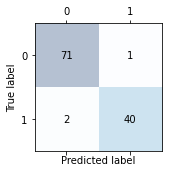

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
        
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

In [15]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score

print(f'Precision: {precision_score(y_true=y_test, y_pred=y_pred):.3f}')
print(f'Recall: {recall_score(y_true=y_test, y_pred=y_pred):.3f}')
print(f'F1: {f1_score(y_true=y_test, y_pred=y_pred):.3f}')

Precision: 0.976
Recall: 0.952
F1: 0.964


## Imbalance

In [16]:
X_imb = np.vstack((X[y == 0], X[y == 1][:40]))
y_imb = np.hstack((y[y == 0], y[y == 1][:40]))

y_pred = np.zeros(y_imb.shape[0])
np.mean(y_pred == y_imb) * 100

89.92443324937027

In [17]:
from sklearn.utils import resample

print(f'Number of class 1 examples before: {X_imb[y_imb == 1].shape[0]}')

X_upsampled, y_upsampled = resample(
    X_imb[y_imb == 1],
    y_imb[y_imb == 1],
    replace=True,
    n_samples=X_imb[y_imb == 0].shape[0],
    random_state=114
)
print(f'Number of class 1 examples after: {X_upsampled.shape[0]}')

Number of class 1 examples before: 40
Number of class 1 examples after: 357


In [18]:
X_bal = np.vstack((X[y == 0], X_upsampled))
y_bal = np.hstack((y[y == 0], y_upsampled))
y_pred = np.zeros(y_bal.shape[0])
np.mean(y_pred == y_bal) * 100

50.0